In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import image_dataset_from_directory, img_to_array, load_img

In [17]:
train_data = image_dataset_from_directory(
    directory="chest_xray/train/",
    image_size=(300, 300), # Change the shape of images to 300x300
    color_mode='rgb',
    label_mode='binary',
    batch_size=40,
    shuffle=True,
    seed=42
)
train_data = train_data.map(lambda x, y: (x / 255.0, y)) # Scale the images between 0 to 1 pixels

Found 5216 files belonging to 2 classes.


In [18]:
test_data = image_dataset_from_directory(
    directory="chest_xray/test/",
    image_size=(300, 300),
    color_mode='rgb',
    label_mode='binary',
    shuffle=False
)
test_data = test_data.map(lambda x, y: (x / 255.0, y))

Found 624 files belonging to 2 classes.


In [19]:
# Iterating over the batch of images :-
first_batch = next(iter(train_data.take(1))) # Returns the first batch of images

batch_images = first_batch[0]
batch_labels = first_batch[1]

print(batch_images.shape)
print(batch_labels[0].numpy().item())
print(batch_labels[10].numpy().item())

(40, 300, 300, 3)
1.0
1.0


In [20]:
x_test = []
for _, label in train_data:
    x_test.extend(label.numpy())
x_test = np.concatenate(x_test).astype(int)

y_test = []
for _, label in test_data:
    y_test.extend(label.numpy())
y_test = np.concatenate(y_test).astype(int)

<Axes: ylabel='count'>

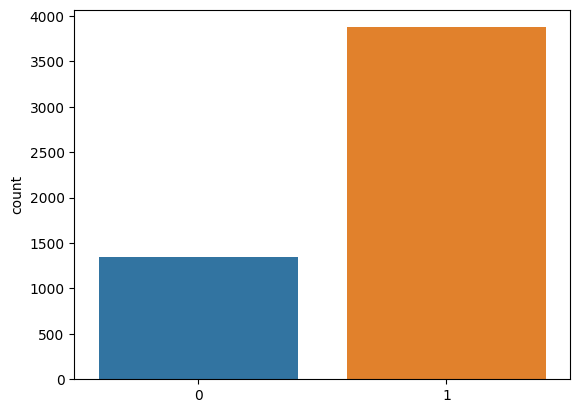

In [21]:
# Number of samples in different classes of the training data :-
sns.countplot(x=x_test)

In [22]:
# Class weights are used to address the issue of class imbalance, where certain classes have a larger number
# of samples compared to others. By assigning higher weights to minority classes and lower weights to
# majority classes, you can give more importance to the underrepresented classes during training.

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(x_test),
    y=x_test
)

# Parsing the array class_weigths into a dictionary :-
class_weights = {index: value for index, value in enumerate(class_weights)}

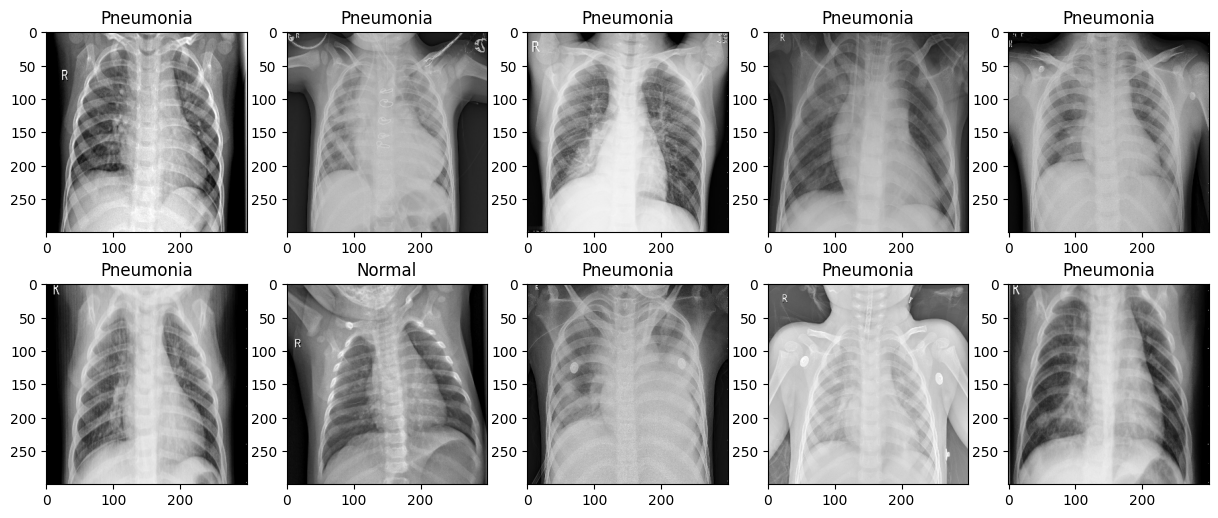

In [23]:
# Plotting the first 10 images :-
first_batch = next(iter(train_data.take(1)))
batch_images = first_batch[0]
batch_labels = first_batch[1]

plt.figure(figsize=(15, 6))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    plt.imshow(batch_images[i])
    title = ['Normal', 'Pneumonia'][int(batch_labels[i].numpy().item())]
    plt.title(title)

In [24]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
# The kernel size defines the dimensions of a small window that moves over an image to extract features and 
# patterns. The kernel performs an operation called convolution which generates a single value that represents
# a feature or characteristic of that specific region of the image. Smaller kernel sizes capture local 
# patterns, such as edges and textures, while larger kernel sizes consider more global structures and 
# relationships between pixels. It is added only to the input layer.

# Input_shape determines (image_height, image_width, color_channels). color_channels=3 refers to (R,G,B).

# The (2, 2) pool size indicates that a 2x2 pooling window will be used. During the max pooling operation, the 
# feature maps will be divided into non-overlapping 2x2 regions, and the maximum value within each region will 
# be selected, resulting in a downsized feature map.

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(300, 300, 3)))
model.add(Dropout(0.2))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D((2, 2)))

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_282 (Conv2D)         (None, 298, 298, 32)      896       
                                                                 
 dropout_4 (Dropout)         (None, 298, 298, 32)      0         


                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 149, 149, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_283 (Conv2D)         (None, 147, 147, 16)      4624      
                                                                 
 dropout_5 (Dropout)         (None, 147, 147, 16)      0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 73, 73, 16)       0         
 g2D)                                                            
                                                                 
Total params: 5,520
Trainable params: 5,520
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# To complete the model, you will feed the last output tensor into one or more Dense layers to perform 
# classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor.
# First, you will flatten (or unroll) the 3D output to 1D, then add one or more Dense layers on top.

model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) # Output tensor

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_282 (Conv2D)         (None, 298, 298, 32)      896       
                                                                 
 dropout_4 (Dropout)         (None, 298, 298, 32)      0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 149, 149, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_283 (Conv2D)         (None, 147, 147, 16)      4624      
                                                                 
 dropout_5 (Dropout)         (None, 147, 147, 16)      0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 73, 73, 16)       0         
 g2D)                                                 

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_data, epochs=2, batch_size=256, validation_data=test_data, class_weight=class_weights)

Epoch 1/2
131/131 [==============================] - 240s 2s/step - loss: 0.4632 - accuracy: 0.8100 - val_loss: 0.4471 - val_accuracy: 0.8045
Epoch 2/2
131/131 [==============================] - 246s 2s/step - loss: 0.1432 - accuracy: 0.9467 - val_loss: 0.6858 - val_accuracy: 0.7356


In [ ]:
predictions = (model.predict(test_data) > 0.5).astype(int)

20/20 [==============================] - 4s 165ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.30      0.46       234
           1       0.70      0.99      0.82       390

    accuracy                           0.74       624
   macro avg       0.84      0.65      0.64       624
weighted avg       0.80      0.74      0.69       624

[[ 71 163]
 [  2 388]]


In [13]:
# The VGG16 architecture consists of 16 convolutional layers with small 3x3 filters followed by max pooling 
# layers. It is a very simple and effective pre-trained CNN model for image classification tasks.
from keras.layers import GlobalAveragePooling2D
from keras.applications import VGG16
# from keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, restore_best_weights=True)

In [ ]:
# Load the pre-trained VGG16 model :-
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(300, 300, 3))
# include_top=False means that the resulting model will consist only of the convolutional layers, which can
# be used as a feature extractor. This is useful when you want to leverage the pre-trained model's learned 
# representations and apply them to a different task or dataset. By adding your own layers on top of the 
# convolutional base, you can adapt the model to your specific needs.

# The weights='imagenet' argument loads the pre-trained weights from the ImageNet dataset. 

for layer in base_model.layers:
    layer.trainable = False
# This loop iterates over each layer in the base_model and sets the trainable attribute of each layer to 
# False. By doing this, you are freezing the weights of the layers in the base model, preventing them from 
# being updated during training.

model_VGG16 = Sequential()
model_VGG16.add(base_model)
model_VGG16.add(GlobalAveragePooling2D()) # Adds a Global Average Pooling layer to the VGG16 model.

model_VGG16.add(Dense(32, activation='relu'))
model_VGG16.add(Dropout(0.2))

model_VGG16.add(Dense(16, activation='relu'))
model_VGG16.add(Dropout(0.2))

model_VGG16.add(Dense(1, activation='sigmoid'))

model_VGG16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_VGG16.fit(train_data, validation_data=test_data, epochs=2, batch_size=64, class_weight=class_weights)

Epoch 1/2
131/131 [==============================] - 1162s 9s/step - loss: 0.4796 - accuracy: 0.7663 - val_loss: 0.3993 - val_accuracy: 0.8253
Epoch 2/2
131/131 [==============================] - 1178s 9s/step - loss: 0.2838 - accuracy: 0.8882 - val_loss: 0.3770 - val_accuracy: 0.8333


In [ ]:
predictions_VGG16 = (model_VGG16.predict(test_data) > 0.5).astype(int)

20/20 [==============================] - 125s 6s/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, predictions_VGG16))
print(confusion_matrix(y_test, predictions_VGG16))

              precision    recall  f1-score   support

           0       0.87      0.65      0.75       234
           1       0.82      0.94      0.88       390

    accuracy                           0.83       624
   macro avg       0.84      0.80      0.81       624
weighted avg       0.84      0.83      0.83       624

[[153  81]
 [ 23 367]]


In [10]:
# The InceptionV3 architecture utilizes a combination of convolutional layers with different filter sizes to 
# capture features at multiple scales. It includes the Inception module, which performs parallel convolutions
# with different filter sizes and concatenates their outputs. InceptionV3 has shown strong performance on
# image classification tasks, especially for complex datasets.

from keras.applications import InceptionV3

In [25]:
base_model_inception = InceptionV3(include_top=False, weights='imagenet', input_shape=(300, 300, 3))

for layer in base_model_inception.layers:
    layer.trainable = False

model_inception = Sequential()

model_inception.add(base_model_inception)
model_inception.add(GlobalAveragePooling2D())

model_inception.add(Dense(32, activation='relu'))
model_inception.add(Dropout(0.2))

model_inception.add(Dense(16, activation='relu'))
model_inception.add(Dropout(0.2))

model_inception.add(Dense(1, activation='sigmoid'))

model_inception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_inception.fit(train_data, validation_data=test_data, epochs=2, batch_size=64, class_weight=class_weights)

Epoch 1/2
131/131 [==============================] - 298s 2s/step - loss: 0.3376 - accuracy: 0.8470 - val_loss: 0.4028 - val_accuracy: 0.8189
Epoch 2/2
131/131 [==============================] - 306s 2s/step - loss: 0.2204 - accuracy: 0.9162 - val_loss: 0.3885 - val_accuracy: 0.8381


In [26]:
predictions_inception = (model_inception.predict(test_data) > 0.5).astype(int)

20/20 [==============================] - 27s 1s/step


In [28]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, predictions_inception))
print(confusion_matrix(y_test, predictions_inception))

              precision    recall  f1-score   support

           0       0.92      0.62      0.74       234
           1       0.81      0.97      0.88       390

    accuracy                           0.84       624
   macro avg       0.86      0.80      0.81       624
weighted avg       0.85      0.84      0.83       624

[[146  88]
 [ 13 377]]


In [30]:
# Predicting for the given validation images :-
val_images = image_dataset_from_directory(
    directory="chest_xray/val/",
    image_size=(300, 300),
    color_mode='rgb',
    label_mode='binary',
    shuffle=False
)
val_images = val_images.map(lambda x, y: (x / 255.0, y))
val_label = []
for _, label in val_images:
    val_label.extend(label.numpy())
val_label = np.concatenate(val_label).astype(int)

val_predictions = (model_inception.predict(val_images) > 0.5).astype(int)

print(classification_report(val_label, val_predictions))
print(confusion_matrix(val_label, val_predictions))

Found 16 files belonging to 2 classes.
1/1 [==============================] - 1s 692ms/step
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.67      1.00      0.80         8

    accuracy                           0.75        16
   macro avg       0.83      0.75      0.73        16
weighted avg       0.83      0.75      0.73        16

[[4 4]
 [0 8]]


In [31]:
# Predicting for a single image :-
img = load_img(
    path="chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg", target_size=(300, 300), color_mode='rgb'
)
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Adds a new dimension of batch_size which is 1 in this case
processed_img = img_array / 255.0

processed_img.shape

(1, 300, 300, 3)

In [32]:
sample_prediction = (model_inception.predict(processed_img) > 0.5).astype(int)
print(sample_prediction)

1/1 [==============================] - 1s 855ms/step
[[1]]


In [54]:
# Exporting the model to a file :-

model_inception.save('my_model.h5')